## Numerical integration of differential equations

In physics, we encounter many, many phenomena which are described by differential equations. A couple examples:

$$i\hbar\frac{\partial}{\partial t}\Psi(\mathbf{r},t) = \left[ \frac{-\hbar^2}{2m}\nabla^2 + V(\mathbf{r},t)\right]\Psi (\mathbf{r},t) \\ 
-\frac{dV}{dx} = m\frac{d^2x}{dt^2}$$

So therefore we had better think about how to solve differential equations in the computer. We will see many different algorithms for this purpose, which one is appropriate will depend on the nature of the diff eq --- degree, partial or ordinary, linear or nonlinear, etc. Let's start with a simple (maybe the simplest) case.

Unstable nuclei ($^{235}U$, e.g.) have a fixed, random probability per unit time to decay into daughter products. This means that over time, an initial number of $^{235}U$ nuclei ($N_0$) in a sample will decrease according to a simple differential equation:

$$\frac{dN}{dt} = -\frac{N(t)}{\tau} \tag{1}$$

It is easy to show (just integrate each side) that the solution is

$$N(t) = N_0e^{-t/\tau} \tag{2}$$

If we set $t=\tau$ we find that $N(t=\tau)/N_0 = e^{-1}$ --- in other words, after a time $\tau$ has elapsed, the initial number of radioactive nuclei has decreased by a bit less than a factor of 3. For $^{235}U$, $\tau \approx 10^9$ years.

### The Euler algorithm

While it is silly to use a computer to integrate such an equation, it is a useful warm-up exercise, and it will introduce us to some of the basic features of numerical integration. And since we know the solution in advance, it is easy to check whether our algorithm works (and also get us thinking about what we mean by "works.")

The simplest thing we can do is write down a Taylor series for the number of nuclei at time $t+\Delta t$, given the number of particles at time $t$:

$$N(t+\Delta t) \approx N(t) + \left. \frac{dN}{dt^{\prime}}\right | _t \Delta t + \mathcal{O}(\Delta t^2)$$

Clearly, this is an *approximation* which drops terms of order $\Delta t^2$ and higher. The quality of the approximation is therefore controlled by the size of $\Delta t$, called the discretization, or (in this case) a timestep. (Although it isn't always the case that making the discretization smaller will improve accuracy...)

Note that the solution depends on first finding the solution at the previous time. We therefore need to start somewhere --- we need to provide an *initial value.* We also need to know the value of the derivative, which in this problem is given by the physics. Our Euler algorithm looks like:

$$N(t+\Delta t) \approx N(t) - \frac{N(t)}{\tau}\Delta t \tag{3}$$

The steps that need to be executed are therefore:
1. Initialize the value of $N(t=0)$
2. Use Eq. 3 to find $N(\Delta t)$
3. Repeat step 2 for a total of n integration steps.

Note that this produces a sequence of pairs of values: $(t_1, N_1), (t_2, N_2),..., (t_n, N_n)$. We will implement this in code and compare to the analytic solution, but first let's talk about non-dimensionalization.

### Dimensionless units

The time constant for $^{235}U$ decay is $10^9$ years. Does it make sense to multiply over and over agion by $10^-9$ in step 2 of our algorithm? Although the likelihood of a floating point error is small in this particular case, this won't always be true. We can avoid some errors of this type by re-writing equations in dimensionless units.

Let's define some timescale, call it $t_0$, (we don't know what it is yet, but it will pop out at thne end), and measure time in these units by defining a dimensionless time $\bar{t}$:

$$\bar{t} = t/t_0$$

Now rewrite Eq. 1 in terms of $\bar{t}$. To do this, note that 

$$\frac{d}{dt} = \frac{d}{d\bar{t}}\frac{d\bar{t}}{dt}= \frac{1}{t_0}\frac{d}{d\bar{t}}$$

With this, Eq. 1 becomes 

$$\frac{1}{t_0}\frac{dN}{d\bar{t}} = -\frac{N}{\tau}$$

Now multiply through by $t_0$:

$$\frac{dN}{d\bar{t}} = -\frac{N}{\tau/t_0}$$

So our nondimensionalization procedure defines for us a new, dimensionless decay constant:

$$\bar{\tau} = \tau/t_0$$

Without loss of generality, we set $\bar{\tau} = 1$, which means that

$$t_0 = \tau$$

and our nondimensionalized equation becomes simply

$$\frac{dN}{d\bar{t}} = - N$$.

The Euler algorithm for the nondimensionalized case is then

$$N(t+\Delta t) \approx N(t) - N(t)\Delta t$$

It may seem silly to go through all this nonsense for such a simple ODE, but later we will use the same procedure on a more complex example.

Now to our Euler code...


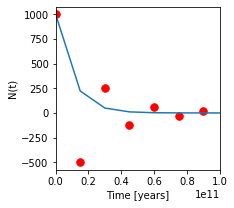

In [63]:
import matplotlib.pyplot as plt
import numpy as np

#initial number of nuclei
N0 = 1000.0
#time constant
tau = 10e9
#this array will hold the timeseries of N(t)
N_t = []
N_t.append(N0)
N_exact = []
N_exact.append(N0)

#this array will hold the physical time
t0 = 0.0
t = []
t.append(t0)

#the timestep. mess around with this to see the behavior...try a range from 2.0 to 0.01
dt = 1.5

#set the max number of integration steps here
max_step = 1000

for i in range(1,max_step):
    #this is the Euler algorithm
    tmp = N_t[i-1] - N_t[i-1]*dt
    N_t.append(tmp)
    
    # we want to report our results in physical units, so lets convert to dimensioned units of time
    # note that i is an integer. I don't know what python will do if I multiply an int and a float,
    # so to be on the safe side I'll recast i as a float
    tmp = float(i)*dt*tau
    t.append(tmp)
    # Here we will store the analytic solution at each time point in an array
    tmp2 = N0*np.exp(-tmp/tau)
    N_exact.append(tmp2)

# Let's also plot the exact solution

plt.figure(1, figsize=(10, 3))
ax = plt.subplot(131)
# uncomment the next line to zoom in
ax.set_xlim(right=10e10)
ax.set_xlabel('Time [years]')
ax.set_ylabel('N(t)')
plt.plot(t,N_t, 'r.', markersize = 15.0)
plt.plot(t, N_exact)


What is going on when we increase the timestep past $1.0$? We have rendered our integration *unstable.* Consider the behavior of our estimate for the number of nuclei remaining $N_i$ at the $i_{th}$ timestep:

$$\begin{align}
N_{i+1} & = N_i - \frac{N_i}{\tau}\Delta t \\
& = N_i\left( 1 - \frac{\Delta t}{\tau} \right)
\end{align}$$

Writing out the first, second, and nth steps:

$$\begin{align}
N_1 & = N_0\left( 1 - \frac{\Delta t}{\tau} \right) \\
N_2 & = N_1\left( 1 - \frac{\Delta t}{\tau} \right) = N_0\left( 1 - \frac{\Delta t}{\tau} \right)^2 \\
N_n & = N_0\left( 1 - \frac{\Delta t}{\tau} \right)^n
\end{align}$$

Notice that the behavior of the solution depends on the value of $\left( 1 - \frac{\Delta t}{\tau} \right)$:

$$\begin{align}
1 > 1-\frac{\Delta t}{\tau} > 0 & \Rightarrow \frac{\Delta t}{\tau} < 1  \Rightarrow \text{monotonically decreasing} \\
-1 < 1-\frac{\Delta t}{\tau} < 0 & \Rightarrow 1 < \frac{\Delta t}{\tau} < 2  \Rightarrow \text{decreasing, oscillates} \\
1-\frac{\Delta t}{\tau} < -1 & \Rightarrow \frac{\Delta t}{\tau} > 2 \Rightarrow \text{growing, unstable}
\end{align}$$

This defines the **stability criterion** for this problem: $\Delta t < 2\tau$.

### Nondimensionalization, cont'd

I've found that this particular topic vexes about 75% of students (note that all faculty were students at one time, so this was once true of faculty as well. Maybe still is! ;0). I'll give you a recipe, then go through a couple examples.

**The recipe**
1. Replace all dynamical variables with normalized values, e.g. $x = \bar{x}x_0$, $t = \bar{t}t_0$, etc.
2. Collect the constants.
3. Choose the lengthscale $x_0$, the timescale $t_0$, etc. to make the equation as simple as possible. You will find that the lengthscale, timescale, etc are now defined in terms of the physical constants in the problem (like $\tau$ above).

Consider a *nonlinear* harmonic oscillator, with a restoring force due to the spring of

$$F_s = -kx -\beta x^3$$

and also subject to a damping that is proportional to velocity:

$$F_D = -Dv$$

The equation of motion is

$$m\frac{d^2x}{dt^2} = -kx - \beta x^3 -Dv \tag{1}$$

Our dynamical variables are:

$$\begin{align}
x &= \bar{x}x_0 \tag{2} \\
t &= \bar{t}t_0 \tag{3} \\
v &= \bar{v}v_0 = \bar{v}\frac{x_0}{t_0} \tag{4}
\end{align}$$

Rewriting the equation of motion (Eq. 1) in terms of the reduced variables $\bar{x}$, etc:

$$\frac{x_0}{t_0^2}m\frac{d^2\bar{x}}{d\bar{t}^2} = -k x_0\bar{x} -\beta x_0^3\bar{x}^3 - D\frac{x_0}{t_0}\bar{v} $$

Now collect the constants --- multiply through by $mt_0^2/x_0$:

$$\frac{d^2\bar{x}}{d\bar{t}^2} = -\frac{kt_0^2}{m}\bar{x} - \beta\frac{x_0^2t_0^2}{m}\bar{x}^3 - \frac{Dt_0}{m}\bar{v}$$

Now we simplify. Here we get to set $x_0$ and $t_0$ to whatever we want...so let's pick them to make the expression as simple as possible. Look at what happens if we set the coefficient of the linear term equal to $1$:

$$\begin{align}
\frac{kt_0^2}{m} &= 1 \\
t_0 &= \sqrt{\frac{m}{k}}
\end{align}$$

**Sanity check:** Does it have the correct units? (Compare to the fundamental frequency of the linear oscillator)

Now we deal with the coefficient of the $x^3$ term in the same way, but this time solving for $x_0$, since we already set the value of $t_0$:

$$\begin{align}
\beta\frac{x_0^2t_0^2}{m} &= 1 \\
x_0 &= \sqrt{\frac{m}{t_0^2\beta}} \\
&= \sqrt{\frac{k}{\beta}} 
\end{align}$$

And this defines our lengthscale $x_0$. Finally, we define a dimensionless drag coefficient $D$ using $t_0$ and $m$:

$$\begin{align}
\bar{D} &= \frac{Dt_0}{m} \\
&= \frac{D}{\sqrt{mk}} 
\end{align}$$

Collecting these definitions, the nmondimensionalized equation of motion becomes:

$$\frac{d^2\bar{x}}{d\bar{t}^2} = -\bar{x} -\bar{x}^3 - \bar{D}\bar{x} \tag{5}$$

(Normally at this point we would drop the overbars on the dynamical variables 'cuz they ugly.) In your code, you would integrate eq. 5, *not* Eq. 1. Then when you report your results, you may want to do so in physical units. In this case, simply convert back to physical units using equations 2, 3, and 4. 